In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import nltk.data
from tqdm import tqdm
import pymorphy3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\genas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
news = pd.DataFrame(pd.read_csv('news.CSV'), columns=['title', 'text'])
news



,title,text
0,"""Калашников"" выпустит партию обновленных АК-12...",\n Во втором полуго...
1,"""Калашников"" начал поставлять снайперскую винт...",\n Поставки новейше...
2,"""Черный май"": как немецкие подводники потерпел...",\n 24 мая исполняет...
3,В РФ продолжают испытывать новый ракетный комп...,\n В России продолж...
4,"За что командир советской подлодки ""Щ-408"" пол...",\n 22 мая исполняет...
...,...,...
1770,ШААЗ выпустил первый отечественный 14-тонный п...,\n «Шадринский авто...
1771,Деятельность «Ростерминалугля» признана эколог...,\n «Ростерминалугол...
1772,«Перспектива» для заслуженного отдыха,\n Почему у нашего ...
1773,«Кузбассразрезуголь» создал первый профстандар...,\n «Кузбассразрезуг...


In [2]:
targets = pd.Series(pd.read_csv('news.CSV')['theme'])
targets

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1770    3.0
1771    3.0
1772    3.0
1773    3.0
1774    3.0
Name: theme, Length: 1775, dtype: float64

In [3]:
def text_to_sentences(text):
    """ Функция делит текст на предложения, а предложения на слова.
    """
    
    # Поделим текст на предложения при помощи NLTK.
    raw_sentences = nltk.sent_tokenize(text, language="russian")
    # Поделим предложения на слова при помощи регулярных выражений, заодно выкинем знаки препинания и цифры.
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(re.findall('[a-zA-Zа-яА-яёЁ]+', raw_sentence.lower()))
    return sentences

In [6]:
text_to_sentences(news['text'][11])

[['госдепартамент',
  'сша',
  'одобрил',
  'потенциальную',
  'продажу',
  'норвегии',
  'шести',
  'многоцелевых',
  'вертолетов',
  'mh',
  'r',
  'об',
  'этом',
  'апреля',
  'сообщило',
  'агентство',
  'по',
  'оборонному',
  'сотрудничеству',
  'сша'],
 ['стоимость',
  'сделки',
  'вместе',
  'с',
  'сопутствующим',
  'вооружением',
  'оценивается',
  'в',
  'млрд',
  'агентство',
  'входящее',
  'в',
  'структуру',
  'минобороны',
  'сша',
  'направило',
  'соответствующее',
  'уведомление',
  'в',
  'конгресс',
  'сша'],
 ['пентагон',
  'заверил',
  'конгрессменов',
  'что',
  'эта',
  'продажа',
  'будет',
  'способствовать',
  'реализации',
  'целей',
  'внешней',
  'политики',
  'сша',
  'путем',
  'повышения',
  'безопасности',
  'одного',
  'из',
  'союзников',
  'по',
  'блоку',
  'нато',
  'пишет',
  'риа',
  'новости'],
 ['вертолет',
  'sikorsky',
  'mh',
  'r',
  'seahawk',
  'производит',
  'компания',
  'lockheed',
  'martin',
  'которой',
  'принадлежит',
  'фирма

In [7]:
news['text'][11]

'\n                            Госдепартамент США одобрил потенциальную продажу Норвегии шести многоцелевых вертолетов MH-60R, об этом 26 апреля сообщило Агентство по оборонному сотрудничеству США. Стоимость сделки вместе с сопутствующим вооружением оценивается в $1 млрд.\nАгентство, входящее в структуру Минобороны США, направило соответствующее уведомление в Конгресс США. Пентагон заверил конгрессменов, что эта продажа будет способствовать реализации целей внешней политики США путем повышения безопасности одного из союзников по блоку НАТО, пишет РИА Новости.\nВертолет Sikorsky MH-60R Seahawk производит компания Lockheed Martin, которой принадлежит фирма Sikorsky.\nSikorsky Aircraft – американская самолетостроительная компания, основанная в 1923 году инженером Игорем Сикорским. Предприятие первым в мире наладило серийный выпуск вертолетов (Sikorsky S-47, 1940 г.)                        '

In [8]:

all_sentences = sum([text_to_sentences(x) for x in news['text']], [])

In [9]:
all_sentences[0]

['во',
 'втором',
 'полугодии',
 'года',
 'концерн',
 'калашников',
 'рассчитывает',
 'представить',
 'первую',
 'серийную',
 'партию',
 'обновленных',
 'ак']

In [10]:
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models import KeyedVectors # Семантические вектора.

In [11]:
model_w2v = KeyedVectors.load_word2vec_format('araneum_upos_skipgram_300_2_2018.vec.gz')

In [12]:
model_w2v['огонь_NOUN']

array([-2.69010e-02,  1.08851e-01,  1.13100e-03, -2.76620e-02,
       -2.50680e-02, -4.58600e-03, -1.26100e-03, -3.79600e-03,
       -7.53080e-02, -2.39490e-02,  2.00400e-02,  6.10330e-02,
        7.40810e-02,  9.56330e-02, -1.11446e-01,  4.60380e-02,
       -2.24540e-02, -2.46080e-02, -8.82250e-02, -1.53180e-02,
       -3.66000e-04, -9.46770e-02,  1.33686e-01,  5.88400e-03,
       -5.05470e-02,  8.13820e-02, -2.88090e-02, -7.00070e-02,
        8.74950e-02, -8.31860e-02, -2.48210e-02, -3.82660e-02,
        6.13210e-02, -6.45530e-02,  2.66400e-03,  8.36140e-02,
       -3.73850e-02,  3.63260e-02, -1.20000e-04, -6.90000e-02,
        1.49810e-02,  3.03880e-02, -2.17280e-02,  2.79400e-02,
       -5.22550e-02,  1.96660e-02,  1.52499e-01,  7.27100e-02,
       -2.11140e-02,  5.69930e-02, -3.07870e-02,  4.09070e-02,
        6.49290e-02,  1.91730e-02,  2.50080e-02, -2.94090e-02,
        6.33780e-02,  1.09028e-01,  5.66630e-02, -3.62330e-02,
        4.96900e-02, -7.09280e-02,  2.74420e-02, -1.986

In [13]:
model_w2v.most_similar('город_NOUN')

[('столица_NOUN', 0.6747552156448364),
 ('грод_NOUN', 0.6577627658843994),
 ('городок_NOUN', 0.6478427052497864),
 ('пригород_NOUN', 0.6212136149406433),
 ('мегаполис_NOUN', 0.6159499883651733),
 ('городый_ADJ', 0.6062526106834412),
 ('город-герой_NOUN', 0.604307234287262),
 ('город-спутник_NOUN', 0.6018998622894287),
 ('населенный_ADJ', 0.5992230772972107),
 ('городишко_NOUN', 0.5902962684631348)]

In [14]:
list(model_w2v.key_to_index.keys())[:20]

['год_NOUN',
 'мочь_VERB',
 'человек_NOUN',
 'время_NOUN',
 'работа_NOUN',
 'новый_ADJ',
 'становиться_VERB',
 'также_ADV',
 'очень_ADV',
 'день_NOUN',
 'первый_ADJ',
 'компания_NOUN',
 'являться_VERB',
 'ребенок_NOUN',
 'иметь_VERB',
 'система_NOUN',
 'место_NOUN',
 'получать_VERB',
 'большой_ADJ',
 'жизнь_NOUN']

In [15]:
lens = np.array([np.linalg.norm(model_w2v[word]) for word in model_w2v.key_to_index.keys()])
lens[lens > 1.01], lens[lens < 0.99], lens[0]

(array([], dtype=float32), array([], dtype=float32), 0.9999996)

In [16]:
model_w2v.most_similar(positive=[u'сербия_PROPN', u'москва_PROPN' ], negative=[u'белград_PROPN'])

[('россия::москва_PROPN', 0.7317757606506348),
 ('россия_PROPN', 0.7260456681251526),
 ('москва::москва_PROPN', 0.7081453204154968),
 ('москва::россия_PROPN', 0.6551341414451599),
 ('россия::санкт-петербург_PROPN', 0.6160128712654114),
 ('рф::москва_PROPN', 0.6140520572662354),
 ('рязань_PROPN', 0.6115250587463379),
 ('россия::украина_PROPN', 0.6086370944976807),
 ('белоруссия_PROPN', 0.6031982898712158),
 ('москва::санкт-петербург_PROPN', 0.6031042337417603)]

In [17]:
import umap
from copy import copy

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 12)

In [18]:
def get_most_frequent_words_from_model(model, texts, threshold=20):
    """ Функция выделяет слова, которые встречаются в текстах texts не реже, чем threshold раз,
        и при этом имеются в предобученной модели model. Также возвращает вектора этих слов.
    """
    vctr = CountVectorizer(lowercase=False)
    cntr = vctr.fit_transform(texts)
    
    res_words = []
    res_vects = []
    summed = cntr.sum(axis=0)
    klist = list(vctr.vocabulary_.keys())
    for i in range(summed.shape[1]):
        if summed[0, i] > threshold:
            try:
                res_vects.append(model[klist[i]])
                res_words.append(klist[i])
            except:
#                 print(klist[i])
                pass
    
    return res_words, res_vects

In [19]:
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy3.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [20]:
sci_sentences = []
n_texts = []
for text in tqdm(news['text']):
    norm = normalizePymorphy(text)
    sci_sentences.append(norm)
    n_texts.append(' '.join(norm))

100%|██████████| 1775/1775 [00:07<00:00, 235.38it/s]


In [21]:
news['text'] = n_texts
news['text']

0       второй_ADJ полугодие_NOUN год_NOUN концерн_NOU...
1       поставка_NOUN новый_ADJ снайперский_ADJ винтов...
2       май_NOUN исполняться_VERB год_NOUN поражение_N...
3       россия_NOUN продолжаться_VERB испытание_NOUN н...
4       май_NOUN исполняться_VERB год_NOUN день_NOUN г...
                              ...                        
1770    шадринский_ADJ автоагрегатный_ADJ завод_NOUN в...
1771    ростерминалуголь_NOUN очередной_ADJ раз_NOUN п...
1772    наш_ADJ народ_NOUN развить_ADJ культура_NOUN л...
1773    кузбассразрезуголь_NOUN сформировать_VERB перв...
1774    кузбассразрезуголь_NOUN приобрести_VERB новый_...
Name: text, Length: 1775, dtype: object

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice
from umap.umap_ import UMAP


C:\Users\genas\AppData\Roaming\Python\Python311\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\genas\AppData\Roaming\Python\Python311\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\genas\AppData\Roaming\Python\Python311\site-packages\umap\distanc

In [23]:
def cluster_texts_and_draw(vectors, umaped_vct, eps):
    """ Функция кластеризует вектора vectors при помощи DBSCAN, используя eps в качестве параметра,
        и отображает их на плоскость, используя umaped_vct.
    """
    # Кластеризуем данные при помощи DBSCAN. 
    # Это не значит, что он лучше k-Means, он просто здесь быстрее.
    db = DBSCAN(eps=eps, min_samples=3)
    db_clusters = db.fit_predict(vectors)
     # Генерируем контрастную карту цветов.
    myclr = ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1))
    print(max(db_clusters))
    fig, ax = plt.subplots()
    ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
    plt.show()
    return db_clusters

def show_texts_in_clusters(texts, target, clust_no, text_no):
    """ Функция отображает группировку текстов texts по кластсерам target.
        Выводит не более text_no текстов из первых clust_no кластеров.
    """

    clusters = list(set(target))

    for c in clusters[:clust_no]:
        print('          __ ', c, ' __')
        cntr = 0
        for i, a in enumerate(texts):
            if target[i] == c:
                print(a[:200])
                cntr += 1
                if cntr == text_no:
                    break
        print()
        
    

In [24]:

news_words, news_vects = get_most_frequent_words_from_model(model_w2v, news['text'], 10)

In [25]:
len(news_words)

3500

In [26]:
len(news_vects)

3500

In [29]:
news_clust_no = int(len(news_vects)/2)
km_clustering = KMeans(n_clusters=sci_clust_no)
news_clusters = km_clustering.fit_predict(news_vects)

C:\Users\genas\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
coi = 1
[word for word, clust in zip(news_words, news_clusters) if clust == coi]

['экономический_ADJ',
 'геополитический_ADJ',
 'внутриполитический_ADJ',
 'конъюнктурный_ADJ']

In [31]:
news_words_sorted = sorted(zip(news_clusters, news_words), key= lambda x:x[0])
# sci_set = set(sci_words)
news_words_d = {w[1]:w[0] for w in news_words_sorted}

In [32]:
clust_no = 22
print([word[1] for word in news_words_sorted if word[0]==clust_no])

['лошадь_NOUN', 'конь_NOUN']


In [33]:
# Посчитаем координаты центроидов.
cur_clust = news_words_sorted[0][0]
cur_coord = np.array(model_w2v[news_words_sorted[0][1]])
cur_count = 1
clust_coord = []

for i, word in enumerate(news_words_sorted[1:]):
    if cur_clust == news_words_sorted[i+1][0]:
        cur_coord += model_w2v[news_words_sorted[i+1][1]]
        cur_count += 1
    else:
        clust_coord.append(cur_coord/cur_count)
        cur_clust = news_words_sorted[i+1][0]
        cur_coord = np.array(model_w2v[news_words_sorted[i+1][1]])
        cur_count = 1
        
clust_coord.append(cur_coord/cur_count)

In [34]:
def text_to_vec_centr(text, model_w2v, clust_coord, news_words_d):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in news_words_d.keys():
            n_words = n_words + 1
            text_vec = np.add(text_vec, clust_coord[news_words_d[word]]) 
        else:
            try:
                text_vec = np.add(text_vec, model_w2v[word]) 
                n_words = n_words + 1
            except Exception:
                pass
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [35]:
# Строим вектора для слов.
news_vect2 = []
for text in tqdm(news.text):
    news_vect2.append(text_to_vec_centr(text, model_w2v, clust_coord, news_words_d))

100%|██████████| 1775/1775 [00:09<00:00, 195.12it/s]


21


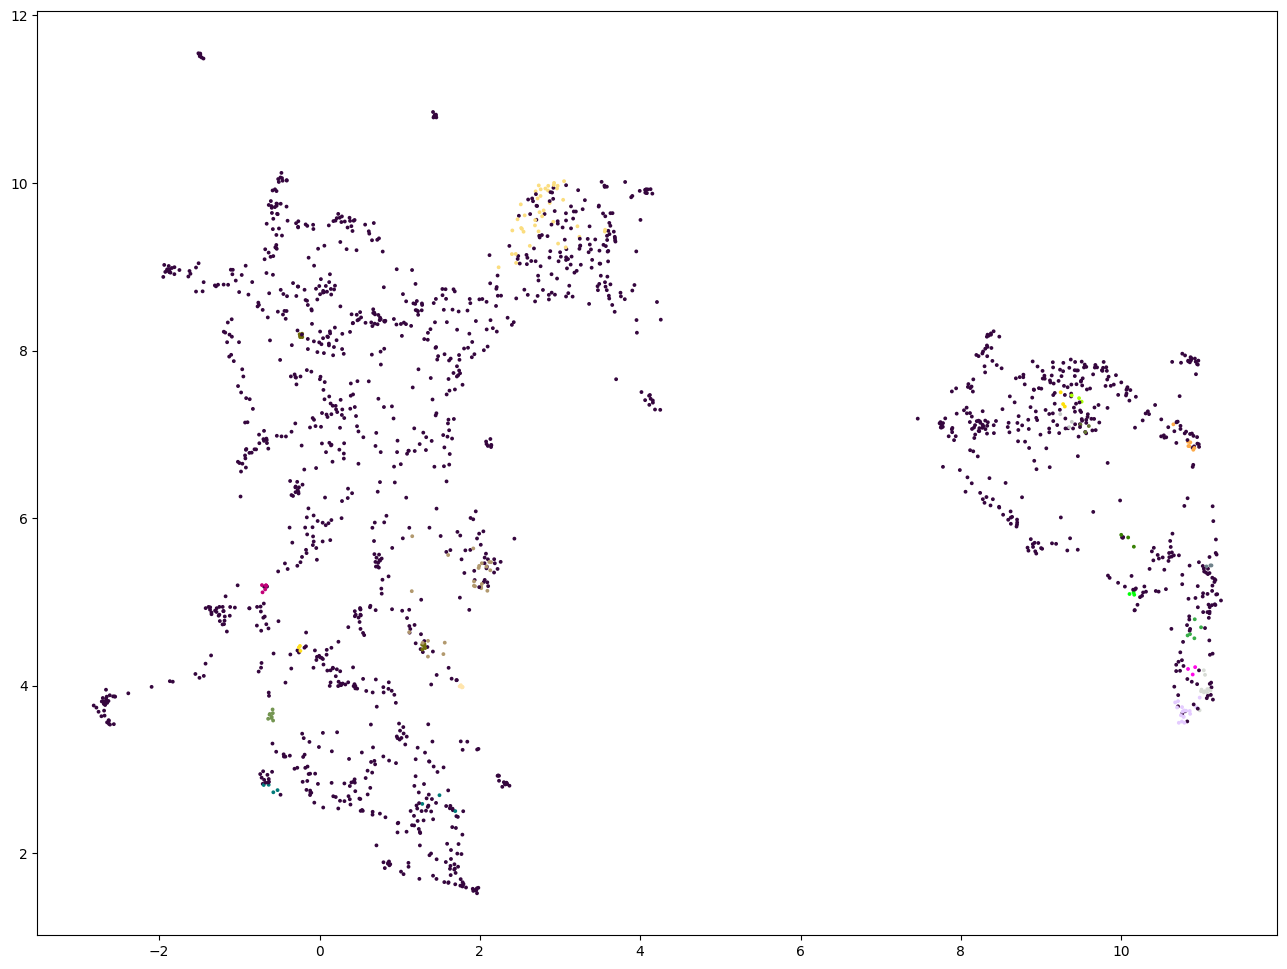

In [36]:
umaped_vct2 = UMAP().fit_transform(news_vect2)
clusters = cluster_texts_and_draw(news_vect2, umaped_vct2, 0.09)

In [37]:
show_texts_in_clusters(news.text, clusters, 10, 3)

          __  0  __
май_NOUN исполняться_VERB год_NOUN день_NOUN гибель_NOUN советский_ADJ подлодка_NOUN щ_NOUN подвиг_NOUN экипаж_NOUN сравнимый_ADJ подвиг_NOUN крейсер_NOUN варяг_NOUN подводник_NOUN пасть_VERB неравный
британский_ADJ военно-морской_ADJ история_NOUN знать_VERB множество_NOUN пример_NOUN подлинный_ADJ героизм_NOUN некоторый_ADJ известный_ADJ упоминать_ADJ другой_ADJ оказываться_VERB слух_NOUN второй_A
ноябрь_NOUN исполниться_VERB год_NOUN день_NOUN рождение_NOUN михаил_NOUN грешилов_NOUN выдающийся_ADJ подводник_NOUN время_NOUN великий_ADJ отечественный_ADJ счёт_NOUN множество_NOUN поход_NOUN торпе

          __  1  __
конец_NOUN лето_NOUN год_NOUN российский_ADJ казна_NOUN быть_VERB принять_ADJ эскадренный_ADJ миноносец_NOUN новик_NOUN корабль_NOUN обладать_VERB высокий_ADJ скорость_NOUN мощный_ADJ артиллерийский_A
лето_NOUN год_NOUN заявить_VERB боевой_ADJ корабль_NOUN новый_ADJ класс_NOUN подводный_ADJ минный_ADJ заградитель_NOUN приоритет_NOUN строительство_NOUN бо

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [39]:
def classify_texts(data, target):
    # Делим данные на обучающую и проверочную выборки.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=333)
    #Обучаем классификатор и оцениваем точность результатов.
    tree = RandomForestClassifier(criterion='entropy', random_state=333)
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    print(f"accuracy = {accuracy_score(y_hat, y_test)}")
    print(confusion_matrix(y_test, y_hat))

In [41]:
targets = np.array(targets)
targets

array([0., 0., 0., ..., 3., 3., 3.])

In [42]:

classify_texts(news_vect2, targets)

accuracy = 0.9352112676056338
[[104   0   0   0]
 [  0  98   0   4]
 [  6   8  37   3]
 [  0   2   0  93]]
